In [1]:
import geopandas as gpd
from rasterio.crs import CRS
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd
from dem_stitcher.geojson_io import read_geojson_gzip
from shapely.geometry import Polygon, shape
import asf_search as asf
import concurrent.futures
from tqdm import tqdm
import mpire
import backoff
import requests
import contextily as cx

In [84]:
START_DATE = '2020-01-01'
END_DATE = '2022-01-01'
MINIMUM_SAMPLES_PER_SITE_AND_BURST = 110 # for prior to December 21, 2021 we expect ~60 samples per year
N_TROPICAL_SITES = 10
TROPICAL_BUFFER_DEG = 5

# Read the disturbance Data

In [3]:
df_dist_hls_val = pd.read_csv('https://raw.githubusercontent.com/OPERA-Cal-Val/DIST-Validation/main/referenceTimeSeries_last.csv')
df_dist_hls_val.head()

,ID,overallLabel,Long,Lat,changetype,20211001,20211002,20211003,20211004,20211005,...,20220921,20220922,20220923,20220924,20220925,20220926,20220927,20220928,20220929,20220930
0,1,VLmaj,-52.379792,-23.297147,Natural browning,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs,noObs
1,2,noChange,129.850328,-29.577240,No Change,noObs,noObs,noObs,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
2,3,VLmin,-98.600559,33.771004,Natural browning,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
3,4,VLmaj,19.332894,4.574903,Fire,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noChange,noChange,noChange,noObs,noObs,noObs
4,5,VLmaj,115.619006,63.108089,Fire,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs


# Extracting "change" and Last observed "no change" indices

In [4]:
def get_index(data: list[str], val: str) -> int:
    try:
        ind = data.index(val)
    except ValueError:
        ind = len(data)
    return ind


def get_first_change(labeled_ts):
    get_index_p = lambda val: get_index(labeled_ts, val)
    indices = list(map(get_index_p, ['VLmin', 'VLmaj', 'OCmin', 'OCmaj']))
    ind = min(indices)
    ind = ind if ind < len(labeled_ts) else -1
    return ind

def get_last_noChange(labeled_ts, change_ind):
    if change_ind == -1:
        return -1
    labeled_ts_r = (labeled_ts[:change_ind][::-1])
    ind_nc_r = get_index(labeled_ts_r, 'noChange')
    ind_nc = change_ind - ind_nc_r - 1
    return ind_nc

Debugging/testing

In [5]:
IND_T = 2
row_data = list(df_dist_hls_val.iloc[IND_T])
ts_labeled = row_data[5:]
ind_c = get_first_change(ts_labeled)
ts_labeled[max(ind_c-10, 0): ind_c+10], ind_c

(['noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin'],
 119)

In [6]:
ind_nc = get_last_noChange(ts_labeled, ind_c)
ts_labeled[max(ind_nc, 0) : ind_c+ 1], ind_c

(['noChange',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'VLmin'],
 119)

## Extract dates from Table

In [7]:
def get_first_change_from_row(row):
    change_label = row['overallLabel']
    if change_label in ['VLmin', 'VLmaj', 'OCmaj', 'OCmin']:
        dates_str = row.keys().tolist()[5:]
        dates = pd.to_datetime(dates_str)
        
        labeled_ts = list(row)[5:]
        ind_c = get_first_change(labeled_ts)
        change_date = dates[ind_c]
    else:
        change_date = pd.NaT
    return change_date

def get_last_obs_date_before_change(row):
    change_label = row['overallLabel']
    if change_label in ['VLmin', 'VLmaj', 'OCmaj', 'OCmin']:
        dates_str = row.keys().tolist()[5:]
        dates = pd.to_datetime(dates_str)
        
        labeled_ts = list(row)[5:]
        ind_c = get_first_change(labeled_ts)
        ind_nc = get_last_noChange(labeled_ts, ind_c)
        last_obs_date = dates[ind_nc] if ind_nc > -1 else pd.NaT
    else:
        last_obs_date = pd.NaT

    return last_obs_date


In [8]:
df_dist_hls_val.head()

,ID,overallLabel,Long,Lat,changetype,20211001,20211002,20211003,20211004,20211005,...,20220921,20220922,20220923,20220924,20220925,20220926,20220927,20220928,20220929,20220930
0,1,VLmaj,-52.379792,-23.297147,Natural browning,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs,noObs
1,2,noChange,129.850328,-29.577240,No Change,noObs,noObs,noObs,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
2,3,VLmin,-98.600559,33.771004,Natural browning,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
3,4,VLmaj,19.332894,4.574903,Fire,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noChange,noChange,noChange,noObs,noObs,noObs
4,5,VLmaj,115.619006,63.108089,Fire,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs


In [9]:
change_times = df_dist_hls_val.apply(get_first_change_from_row, axis=1)
last_obs_times = df_dist_hls_val.apply(get_last_obs_date_before_change, axis=1)
change_labels = df_dist_hls_val.overallLabel[:10]
print(list(zip(change_times,last_obs_times, change_times > last_obs_times ,change_labels)))

[(Timestamp('2021-10-08 00:00:00'), NaT, False, 'VLmaj'), (NaT, NaT, False, 'noChange'), (Timestamp('2022-01-28 00:00:00'), Timestamp('2022-01-06 00:00:00'), True, 'VLmin'), (Timestamp('2021-11-07 00:00:00'), Timestamp('2021-11-02 00:00:00'), True, 'VLmaj'), (Timestamp('2022-05-18 00:00:00'), Timestamp('2022-05-11 00:00:00'), True, 'VLmaj'), (Timestamp('2021-10-03 00:00:00'), NaT, False, 'VLmaj'), (NaT, NaT, False, 'noChange'), (Timestamp('2021-11-12 00:00:00'), Timestamp('2021-11-03 00:00:00'), True, 'OCmin'), (NaT, NaT, False, 'noChange'), (NaT, NaT, False, 'noChange')]


In [10]:
df_sites = gpd.GeoDataFrame({'site_id': df_dist_hls_val.ID,
                             'change_label': df_dist_hls_val.overallLabel,
                             'change_time': change_times,
                             'last_observation_time': last_obs_times},
                             geometry=gpd.points_from_xy(df_dist_hls_val.Long,
                                                         df_dist_hls_val.Lat),
                            crs=CRS.from_epsg(4326))

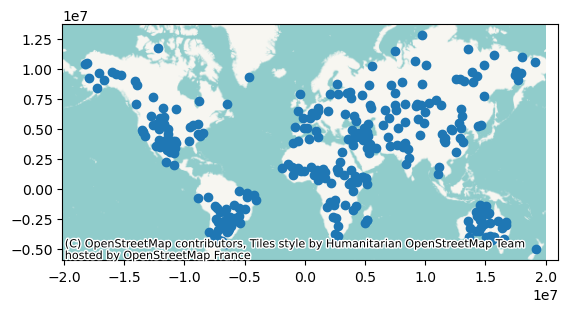

In [11]:
ax = df_sites.to_crs(epsg=3857).plot()
cx.add_basemap(ax)

In [12]:
df_sites.to_file('dist_hls_val_sites.geojson', driver='GeoJSON')

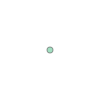

In [13]:
site_lut = df_sites[['site_id', 'geometry']].set_index('site_id').to_dict()
site_lut['geometry'][1]

# Burst Ids

In [14]:
df_burst = read_geojson_gzip('../1_visualize_rtc_time_series/opera_burst_ids.geojson.zip')
df_burst.head()

,geometry,burst_id_jpl,is_land,is_north_america,orbit_pass
0,"POLYGON ((2.53190 4.75701, 3.29631 4.91201, 3....",t001_000025_iw1,1,False,ASCENDING
1,"POLYGON ((3.25912 4.97460, 4.06055 5.13657, 4....",t001_000025_iw2,1,False,ASCENDING
2,"POLYGON ((4.02659 5.18854, 4.73485 5.32978, 4....",t001_000025_iw3,1,False,ASCENDING
3,"POLYGON ((2.49611 4.92361, 3.26087 5.07851, 3....",t001_000026_iw1,1,False,ASCENDING
4,"POLYGON ((3.22392 5.14115, 4.02565 5.30297, 3....",t001_000026_iw2,1,False,ASCENDING


# Join Burst table and the site ids

Via a spatial join

In [15]:
df_val_bursts = gpd.sjoin(df_burst, df_sites, how='inner', predicate='intersects').reset_index(drop=True)
df_val_bursts = df_val_bursts.drop_duplicates()
df_val_bursts = df_val_bursts.drop(columns=['index_right'])
df_val_bursts['track_number'] = df_val_bursts.burst_id_jpl.map(lambda burst_id_jpl: int(burst_id_jpl.split('_')[0][1:]))
df_val_bursts = df_val_bursts.sort_values(by=['site_id', 'burst_id_jpl']).reset_index(drop=True)
df_val_bursts.rename(columns={'burst_id_jpl': 'jpl_burst_id'}, inplace=True)
df_val_bursts.head()

,geometry,jpl_burst_id,is_land,is_north_america,orbit_pass,site_id,change_label,change_time,last_observation_time,track_number
0,"POLYGON ((-52.73133 -23.43816, -51.90414 -23.2...",t090_193169_iw1,1,False,ASCENDING,1,VLmaj,2021-10-08,NaT,90
1,"POLYGON ((-51.66339 -23.30842, -52.52125 -23.1...",t097_207419_iw2,1,False,DESCENDING,1,VLmaj,2021-10-08,NaT,97
2,"POLYGON ((-53.01716 -23.54912, -52.25936 -23.3...",t163_349964_iw3,1,False,ASCENDING,1,VLmaj,2021-10-08,NaT,163
3,"POLYGON ((129.82540 -29.63759, 130.62076 -29.4...",t039_083584_iw3,1,False,ASCENDING,2,noChange,NaT,NaT,39
4,"POLYGON ((130.49640 -29.60892, 129.63063 -29.4...",t075_160202_iw1,1,False,DESCENDING,2,noChange,NaT,NaT,75


In [16]:
df_val_bursts.shape

(1117, 10)

<Axes: >

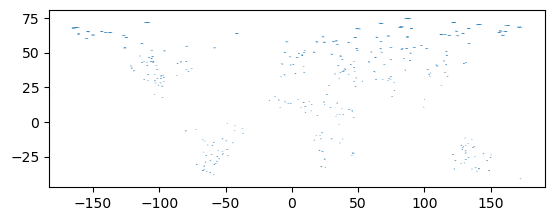

In [17]:
df_val_bursts.plot()

Serializing all the bursts.

In [18]:
df_val_bursts.to_file('dist_val_bursts.geojson', driver='GeoJSON')

# Multiple bursts overlapping

This is particlarly present at high latitudes. We see multiple tracks overlap. We see that there are 11 distinct bursts overlapping site 80!

In [19]:
df_burst_count = df_val_bursts[['site_id', 'orbit_pass']].groupby('site_id').count().sort_values(by='orbit_pass', ascending=False).reset_index(drop=False)
df_burst_count.head(10)

,site_id,orbit_pass
0,80,11
1,36,10
2,45,9
3,85,9
4,49,9
5,157,9
6,81,8
7,71,8
8,39,8
9,218,8


<Axes: >

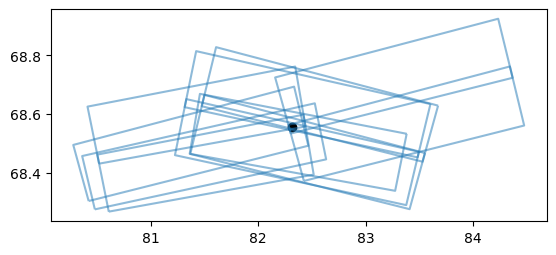

In [20]:
fig, ax = plt.subplots()
df_site = df_sites[df_sites.site_id == 80].plot(ax=ax, color='black')
df_val_bursts[df_val_bursts.site_id == 80].exterior.plot(ax=ax, alpha=.5)

We can better select a suitable burst by calculating the distance from the burst centroid to the Site. This helps find bursts that will likely give us as much context about the site as possible.

In [21]:
def distance_to_site_burst(row):
    poly_cent = row['geometry'].centroid
    site_id = row['site_id']
    site_geo = site_lut['geometry'][site_id]

    dist = site_geo.distance(poly_cent)
    return dist

The sorting of the data

In [22]:
df_val_bursts['dist_from_site_to_burst_centroid'] = df_val_bursts.apply(distance_to_site_burst, axis=1)
df_val_bursts.sort_values(by=['site_id', 'orbit_pass','dist_from_site_to_burst_centroid'], inplace=True)

## Get only 1 bursts from ASC/DSC

Since the data is now ordered by its proximity to the site, we can select the topmost entry in each group of `site_id` and `orbit_pass` (i.e. ascending/descending).

In [23]:
df_val_bursts_filtered = df_val_bursts.groupby(['site_id', 'orbit_pass']).head(1).reset_index(drop=True)
df_val_bursts_filtered.shape, df_val_bursts.shape

((600, 11), (1117, 11))

<Axes: >

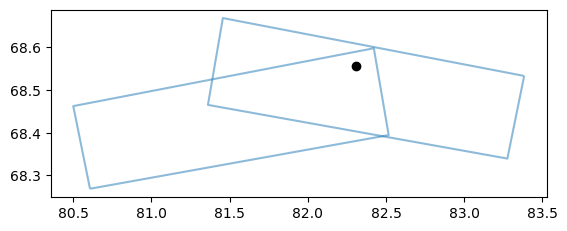

In [24]:
fig, ax = plt.subplots()
df_site = df_sites[df_sites.site_id == 80].plot(ax=ax, color='black')
df_val_bursts_filtered[df_val_bursts_filtered.site_id == 80].exterior.plot(ax=ax, alpha=.5)

# Getting SLC IDs

Now that we have the burst for each ascending/descending pass we will use, we query the ASF DAAC for the SLC metadata we need.

In [25]:
@backoff.on_exception(backoff.expo,
                      (requests.exceptions.ReadTimeout,
                       requests.exceptions.ConnectionError,
                      RuntimeError))
def get_asf_results(*,geo: Point,
                    site_id: int,
                    track_number: int,
                    jpl_burst_id: str,
                    **kwargs):
    
    res = asf.geo_search(platform=[asf.PLATFORM.SENTINEL1],
                         intersectsWith=geo.wkt,
                         #maxResults=5_000,
                         polarization=['VV+VH'], # could add just 'VV'
                         beamMode=[asf.BEAMMODE.IW],
                         relativeOrbit=[track_number],
                         processingLevel=[asf.PRODUCT_TYPE.SLC],
                         start=START_DATE,
                         end=END_DATE
                         )
    df_res = pd.DataFrame()
    if res:
        geometry = [shape(r.geojson()['geometry']) for r in res]
        data = [r.properties for r in res]

        df_res = pd.DataFrame(data)
        df_res = gpd.GeoDataFrame(df_res,
                                  geometry=geometry,
                                  crs=CRS.from_epsg(4326))
        df_res['site_id'] = site_id
        df_res['jpl_burst_id'] = jpl_burst_id

    return df_res

def get_asf_results_from_record(record) -> gpd.GeoDataFrame:
    df = get_asf_results(geo=record['geometry'], site_id=record['site_id'], track_number=record['track_number'], jpl_burst_id=record['jpl_burst_id'])
    return df

We want the site point for the query as it's more exact.

In [26]:
df_query = df_val_bursts_filtered.copy()
df_query = df_query.drop(columns=['geometry'])
df_query = pd.merge(df_query, df_sites[['site_id', 'geometry']], how='left', on='site_id')
df_query.shape

(600, 11)

In [27]:
records = df_query.to_dict('records')
records[:2]

[{'jpl_burst_id': 't090_193169_iw1',
  'is_land': 1,
  'is_north_america': False,
  'orbit_pass': 'ASCENDING',
  'site_id': 1,
  'change_label': 'VLmaj',
  'change_time': Timestamp('2021-10-08 00:00:00'),
  'last_observation_time': NaT,
  'track_number': 90,
  'dist_from_site_to_burst_centroid': 0.06483761782334214,
  'geometry': <POINT (-52.38 -23.297)>},
 {'jpl_burst_id': 't097_207419_iw2',
  'is_land': 1,
  'is_north_america': False,
  'orbit_pass': 'DESCENDING',
  'site_id': 1,
  'change_label': 'VLmaj',
  'change_time': Timestamp('2021-10-08 00:00:00'),
  'last_observation_time': NaT,
  'track_number': 97,
  'dist_from_site_to_burst_centroid': 0.258935889989853,
  'geometry': <POINT (-52.38 -23.297)>}]

In [28]:
get_asf_results_from_record(records[4]).head(2)

,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,url,startTime,sceneName,...,processingDate,sensor,groupID,pgeVersion,fileName,beamModeType,s3Urls,geometry,site_id,jpl_burst_id
0,34.3598,-99.0311,2021-12-23T00:36:53Z,S1A_IW_SLC__1SDV_20211223T003625_20211223T0036...,ASCENDING,107,SLC,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,2021-12-23T00:36:25Z,S1A_IW_SLC__1SDV_20211223T003625_20211223T0036...,...,2021-12-23T00:36:25Z,C-SAR,S1A_IWDV_0107_0114_041129_107,003.40,S1A_IW_SLC__1SDV_20211223T003625_20211223T0036...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1A_IW_SLC_...,"POLYGON ((-100.59006 34.99121, -100.19687 33.3...",3,t107_227877_iw2
1,34.3599,-99.0325,2021-12-11T00:36:54Z,S1A_IW_SLC__1SDV_20211211T003626_20211211T0036...,ASCENDING,107,SLC,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,2021-12-11T00:36:26Z,S1A_IW_SLC__1SDV_20211211T003626_20211211T0036...,...,2021-12-11T00:36:26Z,C-SAR,S1A_IWDV_0107_0114_040954_107,003.40,S1A_IW_SLC__1SDV_20211211T003626_20211211T0036...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1A_IW_SLC_...,"POLYGON ((-100.59154 34.99142, -100.19825 33.3...",3,t107_227877_iw2


In [29]:
#dfs = list(map(get_asf_results_from_record, tqdm(records)))

In [51]:
# with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
#     dfs = list(tqdm(executor.map(get_asf_results_from_record, records[:]), total=len(records)))

In [52]:
df_slcs = pd.concat(dfs, axis=0)
df_slcs.head()

,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,url,startTime,sceneName,...,processingDate,sensor,groupID,pgeVersion,fileName,beamModeType,s3Urls,geometry,site_id,jpl_burst_id
0,-23.6777,-52.2079,2021-12-16T08:55:39Z,S1B_IW_SLC__1SDV_20211216T085512_20211216T0855...,DESCENDING,97,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2021-12-16T08:55:12Z,S1B_IW_SLC__1SDV_20211216T085512_20211216T0855...,...,2021-12-16T08:55:12Z,C-SAR,S1B_IWDV_0670_0676_030048_097,003.40,S1B_IW_SLC__1SDV_20211216T085512_20211216T0855...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1B_IW_SLC_...,"POLYGON ((-51.19835 -24.77103, -50.77159 -23.1...",1,t097_207419_iw2
1,-23.6776,-52.2078,2021-12-04T08:55:39Z,S1B_IW_SLC__1SDV_20211204T085512_20211204T0855...,DESCENDING,97,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2021-12-04T08:55:12Z,S1B_IW_SLC__1SDV_20211204T085512_20211204T0855...,...,2021-12-04T08:55:12Z,C-SAR,S1B_IWDV_0670_0676_029873_097,003.40,S1B_IW_SLC__1SDV_20211204T085512_20211204T0855...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1B_IW_SLC_...,"POLYGON ((-51.19825 -24.77095, -50.77151 -23.1...",1,t097_207419_iw2
2,-23.6783,-52.2085,2021-11-22T08:55:40Z,S1B_IW_SLC__1SDV_20211122T085513_20211122T0855...,DESCENDING,97,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2021-11-22T08:55:13Z,S1B_IW_SLC__1SDV_20211122T085513_20211122T0855...,...,2021-11-22T08:55:13Z,C-SAR,S1B_IWDV_0670_0676_029698_097,003.40,S1B_IW_SLC__1SDV_20211122T085513_20211122T0855...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1B_IW_SLC_...,"POLYGON ((-51.19899 -24.77160, -50.77224 -23.1...",1,t097_207419_iw2
3,-23.6777,-52.2084,2021-11-10T08:55:40Z,S1B_IW_SLC__1SDV_20211110T085513_20211110T0855...,DESCENDING,97,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2021-11-10T08:55:13Z,S1B_IW_SLC__1SDV_20211110T085513_20211110T0855...,...,2021-11-10T08:55:13Z,C-SAR,S1B_IWDV_0670_0676_029523_097,003.40,S1B_IW_SLC__1SDV_20211110T085513_20211110T0855...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1B_IW_SLC_...,"POLYGON ((-51.19887 -24.77111, -50.77205 -23.1...",1,t097_207419_iw2
4,-23.6780,-52.2087,2021-10-29T08:55:40Z,S1B_IW_SLC__1SDV_20211029T085513_20211029T0855...,DESCENDING,97,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2021-10-29T08:55:13Z,S1B_IW_SLC__1SDV_20211029T085513_20211029T0855...,...,2021-10-29T08:55:13Z,C-SAR,S1B_IWDV_0670_0676_029348_097,003.31,S1B_IW_SLC__1SDV_20211029T085513_20211029T0855...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1B_IW_SLC_...,"POLYGON ((-51.19911 -24.77142, -50.77231 -23.1...",1,t097_207419_iw2


Serialize the asf data and remove the `s3Urls` because they require 

In [53]:
df_slcs[[c for c in df_slcs.columns if c not in ['s3Urls']]].to_file('slcs_resp.geojson', driver='GeoJSON',)

# Filtering the SLC data

First we read the data we have serialized (so we don't have to unnecessarily query ASF).

In [54]:
df_slcs = gpd.read_file('slcs_resp.geojson')

Let's first observe there are multiple SLCs for a given pass.

In [55]:
df_slcs['date_acquired_str'] = pd.to_datetime(df_slcs['startTime']).dt.date.map(str)
df_slcs.sort_values(by=['site_id', 'jpl_burst_id', 'date_acquired_str'], inplace=True)

We really only want one SLC for a given burst and date/pass.

In [56]:
df_slcs['date_acquired_str'] = pd.to_datetime(df_slcs['startTime']).dt.date.map(str)
df_slc_per_date_count = df_slcs[['jpl_burst_id', 'date_acquired_str', 'site_id', 'fileID']].groupby(['jpl_burst_id', 'date_acquired_str', 'site_id']).count().sort_values(by='fileID', ascending=False).reset_index(drop=False)
df_slc_per_date_count.iloc[:2]

,jpl_burst_id,date_acquired_str,site_id,fileID
0,t030_062567_iw2,2021-12-17,154,2
1,t100_212834_iw3,2020-06-06,230,2


In [57]:
# df_slcs[df_slcs.jpl_burst_id == 't021_043849_iw2'].head()

There are some sites that actually share bursts/SLCs. An example of two sites with shared burst and 2 SLCs.

In [58]:
df_slcs[(df_slcs.jpl_burst_id == 't042_088909_iw2') & (df_slcs.date_acquired_str == '2021-08-14')][['site_id', 'jpl_burst_id', 'fileID']]

,site_id,jpl_burst_id,fileID
10619,117,t042_088909_iw2,S1B_IW_SLC__1SDV_20210814T140714_20210814T1407...
10620,117,t042_088909_iw2,S1B_IW_SLC__1SDV_20210814T140649_20210814T1407...
15633,166,t042_088909_iw2,S1B_IW_SLC__1SDV_20210814T140714_20210814T1407...
15634,166,t042_088909_iw2,S1B_IW_SLC__1SDV_20210814T140649_20210814T1407...


<Axes: >

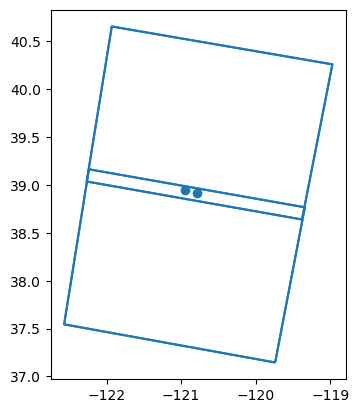

In [59]:
fig, ax = plt.subplots()

df_sites[df_sites.site_id.isin([166, 117])].plot(ax=ax)
df_slcs[(df_slcs.jpl_burst_id == 't042_088909_iw2') & (df_slcs.date_acquired_str == '2021-08-14')].exterior.plot(ax=ax)

### Filtering the SLCs by proximity to Site

Again, we can order the SLCs within flight direction (ascending/descending) and site according to the SLCs proximity to the site.

In [60]:
def distance_to_site_slc(row):
    poly_cent = row['geometry'].centroid
    site_id = row['site_id']
    site_geo = site_lut['geometry'][site_id]

    dist = site_geo.distance(poly_cent)
    return dist

In [61]:
df_slcs['dist_from_site_to_slc_centroid'] = df_slcs.apply(distance_to_site_slc, axis=1)
df_slcs[(df_slcs.jpl_burst_id == 't042_088909_iw2') & (df_slcs.date_acquired_str == '2021-08-14')]

,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,url,startTime,sceneName,...,sensor,groupID,pgeVersion,fileName,beamModeType,site_id,jpl_burst_id,geometry,date_acquired_str,dist_from_site_to_slc_centroid
10619,38.1638,-120.9678,2021-08-14 14:07:41+00:00,S1B_IW_SLC__1SDV_20210814T140714_20210814T1407...,DESCENDING,42,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2021-08-14 14:07:14+00:00,S1B_IW_SLC__1SDV_20210814T140714_20210814T1407...,...,C-SAR,S1B_IWDV_0465_0470_028243_042,003.31,S1B_IW_SLC__1SDV_20210814T140714_20210814T1407...,IW,117,t042_088909_iw2,"POLYGON ((-119.73837 37.14591, -119.33971 38.7...",2021-08-14,0.777644
10620,39.6564,-120.6329,2021-08-14 14:07:16+00:00,S1B_IW_SLC__1SDV_20210814T140649_20210814T1407...,DESCENDING,42,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2021-08-14 14:06:49+00:00,S1B_IW_SLC__1SDV_20210814T140649_20210814T1407...,...,C-SAR,S1B_IWDV_0459_0466_028243_042,003.31,S1B_IW_SLC__1SDV_20210814T140649_20210814T1407...,IW,117,t042_088909_iw2,"POLYGON ((-119.37796 38.63911, -118.97026 40.2...",2021-08-14,0.751915
15633,38.1638,-120.9678,2021-08-14 14:07:41+00:00,S1B_IW_SLC__1SDV_20210814T140714_20210814T1407...,DESCENDING,42,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2021-08-14 14:07:14+00:00,S1B_IW_SLC__1SDV_20210814T140714_20210814T1407...,...,C-SAR,S1B_IWDV_0465_0470_028243_042,003.31,S1B_IW_SLC__1SDV_20210814T140714_20210814T1407...,IW,166,t042_088909_iw2,"POLYGON ((-119.73837 37.14591, -119.33971 38.7...",2021-08-14,0.792319
15634,39.6564,-120.6329,2021-08-14 14:07:16+00:00,S1B_IW_SLC__1SDV_20210814T140649_20210814T1407...,DESCENDING,42,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2021-08-14 14:06:49+00:00,S1B_IW_SLC__1SDV_20210814T140649_20210814T1407...,...,C-SAR,S1B_IWDV_0459_0466_028243_042,003.31,S1B_IW_SLC__1SDV_20210814T140649_20210814T1407...,IW,166,t042_088909_iw2,"POLYGON ((-119.37796 38.63911, -118.97026 40.2...",2021-08-14,0.769297


In [62]:
df_slcs.sort_values(by=['site_id', 'jpl_burst_id', 'date_acquired_str', 'dist_from_site_to_slc_centroid'], inplace=True)
df_slcs_filtered = df_slcs.groupby(['jpl_burst_id', 'date_acquired_str']).head(1)
df_slcs_filtered.shape

(28505, 29)

In [63]:
print('Total unique SLCs needed: ', len(df_slcs_filtered.fileID.unique()))

Total unique SLCs needed:  27158


In [64]:
df_slcs_filtered.to_dict('records')[0]

{'centerLat': -23.6779,
 'centerLon': -52.2075,
 'stopTime': Timestamp('2020-01-08 08:55:26+0000', tz='UTC'),
 'fileID': 'S1B_IW_SLC__1SDV_20200108T085459_20200108T085526_019723_0254A3_BF58-SLC',
 'flightDirection': 'DESCENDING',
 'pathNumber': 97,
 'processingLevel': 'SLC',
 'url': 'https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_SLC__1SDV_20200108T085459_20200108T085526_019723_0254A3_BF58.zip',
 'startTime': Timestamp('2020-01-08 08:54:59+0000', tz='UTC'),
 'sceneName': 'S1B_IW_SLC__1SDV_20200108T085459_20200108T085526_019723_0254A3_BF58',
 'browse': None,
 'platform': 'Sentinel-1B',
 'bytes': 4841509409,
 'md5sum': 'fa5284bd50b9ef3878d0e82a8039c359',
 'frameNumber': 670,
 'granuleType': 'SENTINEL_1B_FRAME',
 'orbit': 19723,
 'polarization': 'VV+VH',
 'processingDate': Timestamp('2020-01-08 08:54:59+0000', tz='UTC'),
 'sensor': 'C-SAR',
 'groupID': 'S1B_IWDV_0670_0676_019723_097',
 'pgeVersion': '003.10',
 'fileName': 'S1B_IW_SLC__1SDV_20200108T085459_20200108T085526_019723_0254A3_BF58

In [85]:
df_slc_per_site_and_fa = df_slcs_filtered[['site_id', 'flightDirection', 'fileID']].groupby(['site_id', 'flightDirection']).count().sort_values(by='fileID', ascending=False).reset_index(drop=False)
df_slc_per_site_and_fa.head()

,site_id,flightDirection,fileID
0,274,DESCENDING,122
1,72,ASCENDING,122
2,34,DESCENDING,122
3,261,DESCENDING,122
4,261,ASCENDING,122


In [86]:
df_slc_per_site_and_fa.iloc[-4:]

,site_id,flightDirection,fileID
410,108,DESCENDING,1
411,269,ASCENDING,1
412,41,ASCENDING,1
413,108,ASCENDING,1


In [87]:
df_slcs_per_burst_and_site = df_slcs_filtered[['site_id', 'flightDirection', 'fileID', 'jpl_burst_id']].groupby(['site_id', 'jpl_burst_id', 'flightDirection']).size().reset_index(name='slc_count')
df_slcs_per_burst_and_site = df_slcs_per_burst_and_site.sort_values(by='slc_count', ascending=False).reset_index(drop=True)
df_slcs_per_burst_and_site.iloc[:4]

,site_id,jpl_burst_id,flightDirection,slc_count
0,72,t005_008692_iw2,ASCENDING,122
1,274,t168_359542_iw2,DESCENDING,122
2,261,t022_045880_iw1,DESCENDING,122
3,261,t175_374038_iw1,ASCENDING,122


In [88]:
df_slcs_filtered[df_slcs_filtered.site_id == 72].head()

,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,url,startTime,sceneName,...,sensor,groupID,pgeVersion,fileName,beamModeType,site_id,jpl_burst_id,geometry,date_acquired_str,dist_from_site_to_slc_centroid
6409,18.2175,-97.7549,2020-01-02 00:39:46+00:00,S1B_IW_SLC__1SDV_20200102T003918_20200102T0039...,ASCENDING,5,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2020-01-02 00:39:18+00:00,S1B_IW_SLC__1SDV_20200102T003918_20200102T0039...,...,C-SAR,S1B_IWDV_0054_0060_019631_005,003.10,S1B_IW_SLC__1SDV_20200102T003918_20200102T0039...,IW,72,t005_008692_iw2,"POLYGON ((-99.09442 18.84322, -98.74429 17.157...",2020-01-02,0.559087
6408,17.7484,-97.6490,2020-01-08 00:40:19+00:00,S1A_IW_SLC__1SDV_20200108T003952_20200108T0040...,ASCENDING,5,SLC,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,2020-01-08 00:39:52+00:00,S1A_IW_SLC__1SDV_20200108T003952_20200108T0040...,...,C-SAR,S1A_IWDV_0053_0058_030702_005,003.10,S1A_IW_SLC__1SDV_20200108T003952_20200108T0040...,IW,72,t005_008692_iw2,"POLYGON ((-98.98597 18.34434, -98.64812 16.715...",2020-01-08,0.234763
6407,18.2175,-97.7551,2020-01-14 00:39:45+00:00,S1B_IW_SLC__1SDV_20200114T003917_20200114T0039...,ASCENDING,5,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2020-01-14 00:39:17+00:00,S1B_IW_SLC__1SDV_20200114T003917_20200114T0039...,...,C-SAR,S1B_IWDV_0054_0060_019806_005,003.10,S1B_IW_SLC__1SDV_20200114T003917_20200114T0039...,IW,72,t005_008692_iw2,"POLYGON ((-99.09460 18.84328, -98.74450 17.158...",2020-01-14,0.559234
6406,17.7485,-97.6494,2020-01-20 00:40:18+00:00,S1A_IW_SLC__1SDV_20200120T003952_20200120T0040...,ASCENDING,5,SLC,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,2020-01-20 00:39:52+00:00,S1A_IW_SLC__1SDV_20200120T003952_20200120T0040...,...,C-SAR,S1A_IWDV_0052_0058_030877_005,003.10,S1A_IW_SLC__1SDV_20200120T003952_20200120T0040...,IW,72,t005_008692_iw2,"POLYGON ((-98.98628 18.34420, -98.64848 16.715...",2020-01-20,0.235084
6405,18.2178,-97.7552,2020-01-26 00:39:45+00:00,S1B_IW_SLC__1SDV_20200126T003917_20200126T0039...,ASCENDING,5,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2020-01-26 00:39:17+00:00,S1B_IW_SLC__1SDV_20200126T003917_20200126T0039...,...,C-SAR,S1B_IWDV_0054_0060_019981_005,003.10,S1B_IW_SLC__1SDV_20200126T003917_20200126T0039...,IW,72,t005_008692_iw2,"POLYGON ((-99.09477 18.84355, -98.74468 17.158...",2020-01-26,0.559556


In [89]:
df_slcs_per_burst_and_site.iloc[-4:]

,site_id,jpl_burst_id,flightDirection,slc_count
410,108,t130_277443_iw3,ASCENDING,1
411,269,t149_319844_iw1,ASCENDING,1
412,41,t083_176383_iw2,ASCENDING,1
413,108,t050_105959_iw2,DESCENDING,1


Simply due to S1A/S1B availability, we see that certain bursts have less than the expected number of samples. Filtering by frequency ensure we will have a dense time series.

In [108]:
df_val_bursts_with_count = pd.merge(df_val_bursts_filtered, 
                                   df_slcs_per_burst_and_site[['site_id', 'jpl_burst_id', 'slc_count']], 
                                  on=['site_id','jpl_burst_id'], 
                                  how='left')
# Some bursts have no counts and are therefore NA
df_val_bursts_with_count.dropna(axis=0, subset=['slc_count'], inplace=True)
df_val_bursts_with_count.head()

,geometry,jpl_burst_id,is_land,is_north_america,orbit_pass,site_id,change_label,change_time,last_observation_time,track_number,dist_from_site_to_burst_centroid,slc_count
1,"POLYGON ((-51.66339 -23.30842, -52.52125 -23.1...",t097_207419_iw2,1,False,DESCENDING,1,VLmaj,2021-10-08,NaT,97,0.258936,60.0
3,"POLYGON ((130.49640 -29.60892, 129.63063 -29.4...",t075_160202_iw1,1,False,DESCENDING,2,noChange,NaT,NaT,75,0.182747,58.0
4,"POLYGON ((-99.31968 33.56634, -98.35539 33.705...",t107_227877_iw2,1,True,ASCENDING,3,VLmin,2022-01-28,2022-01-06,107,0.257018,60.0
7,"POLYGON ((19.82686 4.63062, 19.12143 4.78148, ...",t036_076228_iw3,1,False,DESCENDING,4,VLmaj,2021-11-07,2021-11-02,36,0.122383,120.0
9,"POLYGON ((115.83357 63.15873, 114.26731 63.282...",t091_194011_iw3,1,False,DESCENDING,5,VLmaj,2022-05-18,2022-05-11,91,0.611896,27.0


In [117]:
sufficient_sampling_ind = df_val_bursts_with_count.slc_count >= MINIMUM_SAMPLES_PER_SITE_AND_BURST
bursts_with_enough_samples = df_val_bursts_with_count[sufficient_sampling_ind].jpl_burst_id.unique()
print('Total bursts with enough samples: ', (sufficient_sampling_ind).sum())
print('Total bursts available (i.e. with SLCs): ', len(df_val_bursts_with_count.jpl_burst_id.unique()))

Total bursts with enough samples:  82
Total bursts available:  414


In [120]:
sites_with_enough_samples = df_val_bursts_with_count[sufficient_sampling_ind].site_id.unique().tolist()
print('Total sites with enough samples: ', len(sites_with_enough_samples))
print('Total sites available (i.e. with SLCs): ', len(df_val_bursts_with_count.site_id.unique()))

Total sites with enough samples:  49
Total sites available (i.e. with SLCs):  289


In [121]:
df_val_bursts_tropical = df_val_bursts_with_count.cx[:, -TROPICAL_BUFFER_DEG: TROPICAL_BUFFER_DEG].reset_index(drop=True)
df_val_bursts_tropical_top = df_val_bursts_tropical.sort_values(by=['slc_count'], ascending=False).head(N_TROPICAL_SITES)
print(df_val_bursts_tropical_top.slc_count.sum())
df_val_bursts_tropical_top.head()

675.0


,geometry,jpl_burst_id,is_land,is_north_america,orbit_pass,site_id,change_label,change_time,last_observation_time,track_number,dist_from_site_to_burst_centroid,slc_count
0,"POLYGON ((19.82686 4.63062, 19.12143 4.78148, ...",t036_076228_iw3,1,False,DESCENDING,4,VLmaj,2021-11-07,2021-11-02,36,0.122383,120.0
3,"POLYGON ((33.63176 4.04588, 32.87115 4.21002, ...",t123_263100_iw1,1,False,DESCENDING,73,VLmin,2021-12-12,2021-12-06,123,0.133175,92.0
1,"POLYGON ((-48.48824 -1.27442, -49.28340 -1.097...",t170_364085_iw2,1,False,DESCENDING,66,noChange,NaT,NaT,170,0.078428,64.0
9,"POLYGON ((-42.63028 -2.73766, -43.42608 -2.559...",t126_269585_iw2,1,False,DESCENDING,288,VLmaj,2021-10-03,NaT,126,0.310546,64.0
2,"POLYGON ((33.10028 3.85437, 33.80708 3.99703, ...",t029_060159_iw3,1,False,ASCENDING,73,VLmin,2021-12-12,2021-12-06,29,0.083633,61.0


In [122]:
top_tropical_bursts = df_val_bursts_tropical_top.jpl_burst_id.unique()
print('SLCs used for tropical coverage: ', len(df_slcs_filtered[df_slcs_filtered.jpl_burst_id.isin(top_tropical_bursts)].fileID.unique()))

SLCs used for tropical coverage:  675


<Axes: >

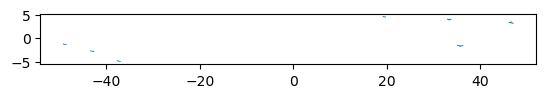

In [123]:
df_val_bursts_tropical_top.plot()

In [124]:
ind_samples = df_slcs_filtered.jpl_burst_id.isin(bursts_with_enough_samples)

tropical_burst_ids = df_val_bursts_tropical_top.jpl_burst_id.unique().tolist()
ind_tropical = df_slcs_filtered.jpl_burst_id.isin(tropical_burst_ids)

df_slcs_final = df_slcs_filtered[ind_samples | ind_tropical].reset_index(drop=True)
print('Final tally of SLCs: ', len(df_slcs_final.fileID.unique()))

Final tally of SLCs:  9678


Let's visualize the sites

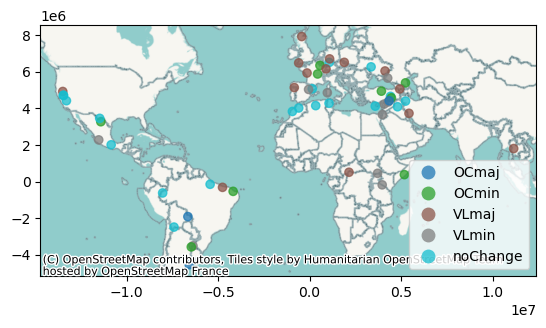

In [125]:
ax = df_sites[df_sites.site_id.isin(df_slcs_final.site_id.unique())].to_crs(epsg=3857).plot(alpha=.75,column='change_label', categorical=True, legend=True)
cx.add_basemap(ax)

We can now plot the SLC frames with a given site.

In [126]:
df_slcs_final.site_id.unique()

array([  4,  13,  22,  30,  34,  40,  55,  66,  72,  73,  87,  90,  95,
        98, 104, 117, 126, 147, 148, 150, 154, 158, 166, 172, 175, 178,
       180, 189, 192, 204, 205, 206, 212, 222, 224, 226, 228, 235, 248,
       249, 250, 251, 255, 256, 261, 263, 264, 270, 272, 274, 287, 288,
       292, 294, 299])

<Axes: >

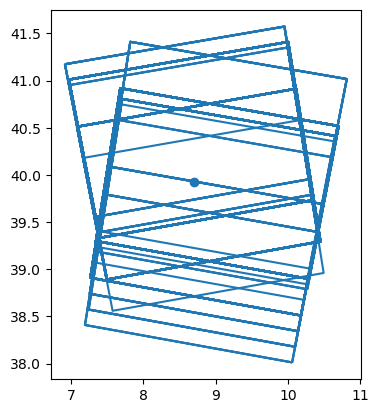

In [130]:
fig, ax = plt.subplots()

site_id_sample = 274
df_slcs_final[df_slcs_final.site_id == site_id_sample].exterior.plot(ax =ax)
df_sites[df_sites.site_id == site_id_sample].plot(ax=ax)

In [128]:
compression_options = dict(method='zip', archive_name=f'slcs_for_processing.csv')
df_slcs_filtered.to_csv('slcs_for_processing.csv.zip', compression=compression_options, index=False)

In [129]:
(len(df_slcs_final.fileID.unique())) * .35

3387.2999999999997